Previsão do preço do Bitcoin.

Dataset adquirido da Coinmarketcap.

[Bitcoin Price History](https://coinmarketcap.com/currencies/bitcoin/historical-data/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2025-05-03 14:16:01.482623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746292561.498246  115045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746292561.502460  115045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746292561.513270  115045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746292561.513292  115045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746292561.513293  115045 computation_placer.cc:177] computation placer alr

In [2]:
# Verificando uso da GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Visualização dos dados

In [3]:
df = pd.read_csv('Bitcoin_22_04_2013-21_04_2025_historical_data_coinmarketcap.csv', sep=';')
df.sort_values(ascending=True, by='timeClose', inplace=True) # Ordena do menor valor de timestamp para o maior
df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
626,2013-04-22T00:00:00.000Z,2013-04-28T23:59:59.999Z,2013-04-28T18:50:02.000Z,2013-04-28T20:15:02.000Z,2781,135.300003,135.979996,132.100006,134.210007,0.0,1.488567e+09,2013-04-28T23:59:59.999Z
625,2013-04-29T00:00:00.000Z,2013-05-05T23:59:59.999Z,2013-04-29T13:15:01.000Z,2013-05-03T03:05:01.000Z,2781,134.444000,147.488007,79.099998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z
624,2013-05-06T00:00:00.000Z,2013-05-12T23:59:59.999Z,2013-05-06T14:25:01.000Z,2013-05-07T14:35:02.000Z,2781,115.980003,124.663002,97.699997,115.000000,0.0,1.281983e+09,2013-05-12T23:59:59.999Z
623,2013-05-13T00:00:00.000Z,2013-05-19T23:59:59.999Z,2013-05-17T17:40:02.000Z,2013-05-15T00:25:01.000Z,2781,114.820000,125.300003,103.500000,121.989998,0.0,1.363205e+09,2013-05-19T23:59:59.999Z
622,2013-05-20T00:00:00.000Z,2013-05-26T23:59:59.999Z,2013-05-26T15:15:02.000Z,2013-05-20T04:45:03.000Z,2781,122.500000,136.000000,120.120003,133.479996,0.0,1.495293e+09,2013-05-26T23:59:59.999Z


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 626 to 0
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeOpen   627 non-null    object 
 1   timeClose  627 non-null    object 
 2   timeHigh   627 non-null    object 
 3   timeLow    627 non-null    object 
 4   name       627 non-null    int64  
 5   open       627 non-null    float64
 6   high       627 non-null    float64
 7   low        627 non-null    float64
 8   close      627 non-null    float64
 9   volume     627 non-null    float64
 10  marketCap  627 non-null    float64
 11  timestamp  627 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 63.7+ KB


Text(0, 0.5, 'Valor US$')

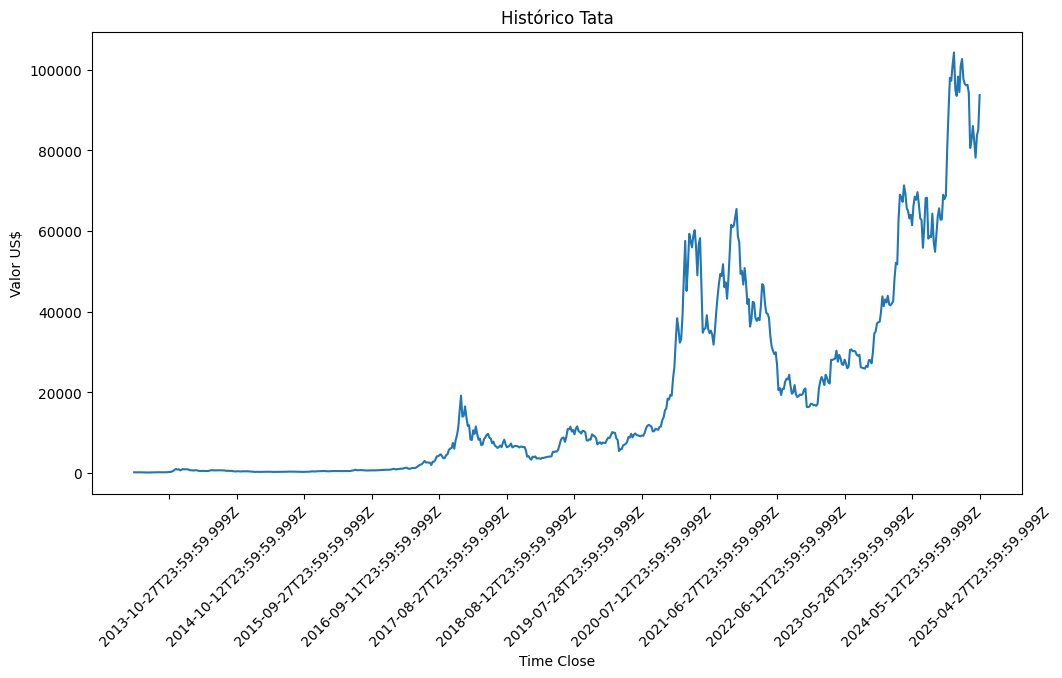

In [5]:
plt.figure(figsize=(12,6))
plt.title('Histórico Tata')
sns.lineplot(data=df, x='timeClose', y='close')
plt.xticks(df['timeClose'][-1:0:-50], rotation=45) # Exibe o eixo x de 50 em 50
plt.xlabel('Time Close')
plt.ylabel('Valor US$')

### Pré-processamento dos dados de séries temporais

In [6]:
# Criando uma função para realizar a preparação de séries temporais de forma manual
def window_view(array, n_length):
    X, y = [], []

    # O loop começara com n_length
    for i in range(n_length, len(array)):

        # Faz uma subtração com a iteração atual e a quantidade de passos
        X.append(array[i-n_length:i]) # Janela de entrada
        y.append(array[i]) # Valor de saída 

    return np.array(X), np.array(y)

In [7]:
training_set = df['close'].values # Adquirindo os valores de fechamento para treinamento da série temporal
training_set[0:10]

array([134.21000671, 115.91000366, 115.        , 121.98999786,
       133.47999573, 122.29199982, 100.        ,  99.51000214,
       107.59999847,  96.61399841])

In [8]:
training_set.reshape(-1, 1).shape

(627, 1)

Normalização dos dados

In [9]:
mm = MinMaxScaler()
training_set_scaled = mm.fit_transform(training_set.reshape(-1, 1))

In [10]:
training_set_scaled[0:10]

array([[0.00057231],
       [0.00039673],
       [0.000388  ],
       [0.00045507],
       [0.00056531],
       [0.00045796],
       [0.00024408],
       [0.00023938],
       [0.000317  ],
       [0.00021159]])

Divisão dos dados em treino e validação.

In [11]:
y_train, y_val = train_test_split(training_set_scaled, test_size=0.2, shuffle=False)
#y_val, y_test = train_test_split(y_temp, test_size=0.4, shuffle=False)

In [12]:
WINDOW_LENGHT = 50

In [13]:
X_train_ts, y_train_ts = window_view(y_train, WINDOW_LENGHT)
X_val_ts, y_val_ts = window_view(y_val, WINDOW_LENGHT)
#X_test_ts, y_test_ts = window_view(y_test, WINDOW_LENGHT)

In [14]:
X_train_ts.shape # 2D (samples, timesteps)

(451, 50, 1)

In [15]:
# Transformando em matriz (3 dimensões) para ser compatível com a entrada da rede neural
X_train_ts = X_train_ts.reshape(X_train_ts.shape[0], X_train_ts.shape[1], 1)
X_val_ts = X_val_ts.reshape(X_val_ts.shape[0], X_val_ts.shape[1], 1)
#X_test_ts = X_test_ts.reshape(X_test_ts.shape[0], X_test_ts.shape[1], 1)

In [16]:
X_train_ts.shape # 3D (samples, timesteps, features)
# samples: número de exemplos no batch (ou dataset)
# timesteps: número de passos temporais (ou tamanho da janela)
# features: número de variáveis por passo (por tempo)

(451, 50, 1)

### Criação da arquitetura da rede neural recorrente

In [17]:
model = Sequential([
    LSTM(units=50,
         return_sequences=True, # Garante que a camada LSTM retorne uma sequência completa (shape (batch_size, timesteps, units))
         input_shape=(X_train_ts.shape[1], X_train_ts.shape[2])), # Define como qtd de passos e qtd de features
    Dropout(0.2),
    
    LSTM(units=50,
         return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50,
         return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50),
    Dropout(0.2),
    
    Dense(units=1) # Caso não for especificado a função de ativação, será "linear"
])

I0000 00:00:1746292564.263967  115045 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/wolf/anaconda3/envs/ai_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(loss=MeanSquaredError(),
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=[R2Score()])

In [19]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(monitor='val_loss',
                             filepath='best_model_recurrent_LSTM.keras',
                             save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)]

In [20]:
history = model.fit(X_train_ts, y_train_ts,
                    batch_size=32,
                    validation_data=(X_val_ts, y_val_ts),
                    callbacks=callbacks,
                    epochs=100)

Epoch 1/100


I0000 00:00:1746292566.981847  115115 cuda_dnn.cc:529] Loaded cuDNN version 90300


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0273 - r2_score: -0.3521 - val_loss: 0.2901 - val_r2_score: -7.9683 - learning_rate: 1.0000e-04
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 0.0161 - r2_score: 0.2785 - val_loss: 0.2086 - val_r2_score: -5.4486 - learning_rate: 1.0000e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ -59s 38ms/step - loss: 0.0150 - r2_score: 0.4031 - val_loss: 0.1588 - val_r2_score: -3.9093 - learning_rate: 1.0000e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0115 - r2_score: 0.5563 - val_loss: 0.1018 - val_r2_score: -2.1481 - learning_rate: 1.0000e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0088 - r2_score: 0.5917 - val_loss: 0.1079 - val_r2_score: -2.3366 - learning_rate: 1.0000e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0067 - r2_score: 0.7097 - val_loss: 0.0738 - val_r2_score: -1.2800 - learning_rate: 1.0000e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0077 -

In [21]:
def view_history(model_history):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("R² por época")
    plt.plot(model_history.history['r2_score'])
    plt.plot(model_history.history['val_r2_score'])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel("Época")
    plt.ylabel("R²")
    
    plt.subplot(1,2,2)
    plt.title("Perda por época")
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel("Época")
    plt.ylabel("Perda")

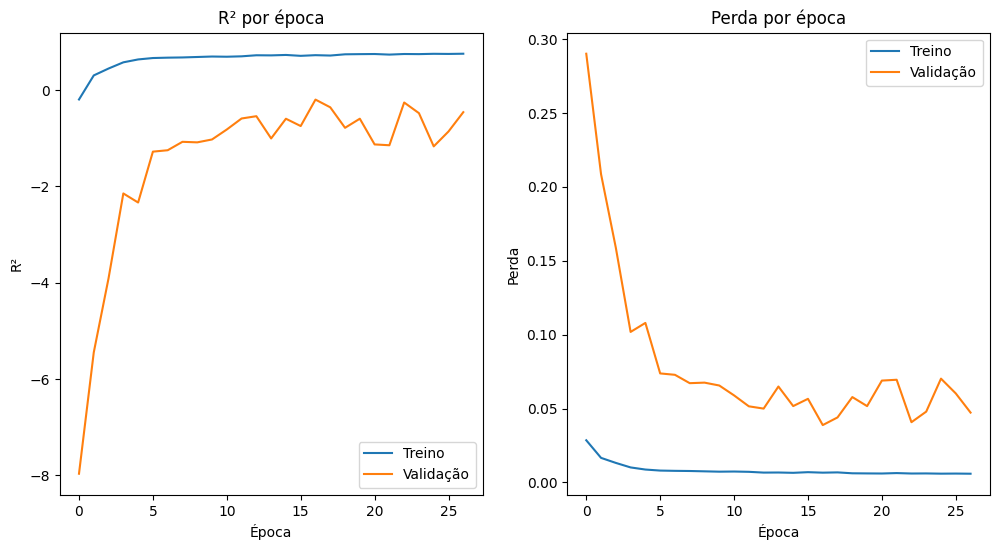

In [22]:
view_history(history)

Predição dos dados de validação para verificar como o modelo se ajustou as variações de preço.

In [23]:
y_val_predicts = model.predict(X_val_ts)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Voltando aos valores de preço originais (não escalados/normalizados com MinMaxScaler).

In [24]:
y_val = mm.inverse_transform(y_val)
y_val_predicts = mm.inverse_transform(y_val_predicts)

<Axes: xlabel='timeClose'>

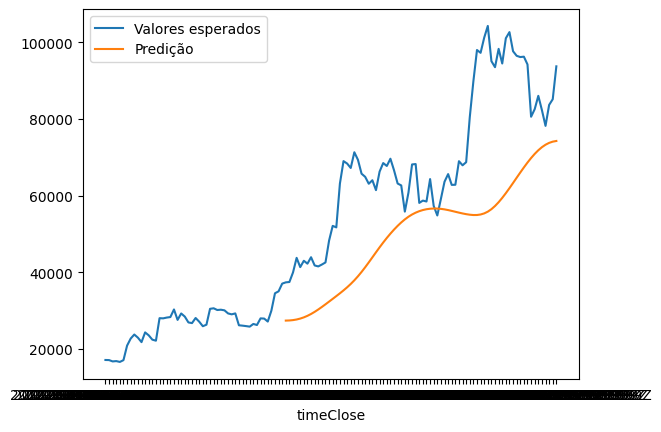

In [25]:
# Exibindo dados reais x dados previstos (inferidos, predição)
sns.lineplot(x='timeClose', y=y_val[:,0], data=df[len(y_train):len(df)], label='Valores esperados')
sns.lineplot(x='timeClose', y=y_val_predicts[:,0], data=df[len(y_train) + WINDOW_LENGHT:len(df)], label='Predição')

### Conclusão

Pelo fato de valores de ações e de criptomoedas serem influenciadas diretamente pela economia, contexto político e etc, não é possível prever com precisão os valores de variação do bitcoin apenas com o histórico de valores ao longo do tempo. Talvez seja necessário outros paramêtros, ou até mesmo, reduzir o histórico para que seja possível prever a variação dos preços em poucos dias, com a finalidade para fazer day trades, por exemplo.